In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [20]:
def imshow(im):
    width, height, *channels = im.shape
    if channels:
        # By default, OpenCV tends to work with images in the BGR format.
        # This is due to some outdated practices, but it has been left in the library.
        # We can iterate the channels in reverse order to get an RGB image.
        plt.imshow(im[:,:,::-1])
    else:
        plt.imshow(im, cmap='gray')
    # plt.axis('off')
    plt.show()

def remove_shadow(image: np.ndarray, blockSize):
  mean = cv2.blur(image, (blockSize, blockSize))
  no_shadow = image / mean
  return cv2.normalize(no_shadow, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)


def reorder(vertices):
    # OpenCV *prefers* if we use `np.float32`.
    reordered = np.zeros_like(vertices, dtype=np.float32)
    add = vertices.sum(1)
    reordered[0] = vertices[np.argmin(add)]
    reordered[2] = vertices[np.argmax(add)]
    diff = np.diff(vertices, axis=1)
    reordered[1] = vertices[np.argmin(diff)]
    reordered[3] = vertices[np.argmax(diff)]
    return reordered

def transform(image,cornerpoints):
  cornerpoints = reorder(cornerpoints)
  print(cornerpoints)
  # Assign the corner points to variables
  (w1, w2, h1, h2) = cornerpoints

  # Calculate the width and height of the image
  FirstWidth = np.sqrt((((w2[1] - w1[1]) ** 2) + (w2[0] - w1[0]) ** 2))
  SecondWidth = np.sqrt((((h1[1] - h2[1]) ** 2) + (h1[0] - h2[0]) ** 2))
  FirstHeight = np.sqrt((((w2[1] - h1[1]) ** 2) + (w2[0] - h1[0]) ** 2))
  SecondHeight = np.sqrt((((w1[1] - h2[1]) ** 2) + (w1[0] - h2[0]) ** 2))

  # Determine the best width and height
  BestWidth = max(int(FirstWidth), int(SecondWidth))
  BestHeight = max(int(FirstHeight), int(SecondHeight))

  # Define the destination points for the perspective transform
  a = [0, 0]
  b = [BestWidth - 1, 0]
  c = [BestWidth - 1, BestHeight - 1]
  d = [0, BestHeight - 1]
  dest = np.array([ a, b, c, d], dtype = "float32")

  # Get the perspective transform matrix
  M = cv2.getPerspectiveTransform(cornerpoints, dest)

  # Apply the perspective transform to the image
  finalimg = cv2.warpPerspective(image, M, (BestWidth, BestHeight))

  # # Display the cropped image
  # plt.imshow(finalimg )
  return  finalimg

def project(image):
  img1=image.copy()
  grayimg = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype('uint8')
  bilateralimg = cv2.bilateralFilter(grayimg, 10, 10, 10)
  th2 = cv2.adaptiveThreshold(bilateralimg,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,5,2)
  edgesimg = cv2.Canny(th2, 50, 60, None, 3)
  kernel_dilate = np.ones((5, 5), np.uint8)
  img_dilate = cv2.dilate(edgesimg , kernel_dilate, iterations=1)

  # Find contours in the image
  contours, hierarchy = cv2.findContours(img_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  max_area = 0
  max_contour = []
  for c in contours:
      # Find the contour perimeter
      perimeter = cv2.arcLength(c, True)
      # Approximate the paper's contour with approxPolyDP function
      approx = cv2.approxPolyDP(c, 0.02 * perimeter, True)
      area = cv2.contourArea(c)
      cornerpoints=[]
      # If the contour has four sides, show it
      if len(approx) ==4 and area>max_area:
          max_area = area
          max_contour = approx
      # print(len(max_contour))
  if len(max_contour)>0:
        cv2.drawContours(img1, [max_contour], -1, (0, 255, 0), 2)
        for point in max_contour:
            x, y = point.ravel()
            cornerpoints.append([x,y])
  cornerpoints=np.array(cornerpoints, dtype = 'object')
  cornerpoints=np.float32(cornerpoints)
  print(cornerpoints)
  plt.scatter([x for x, y in cornerpoints], [y for x, y in cornerpoints])
  imshow(img1)
  img2=image.copy()
  finalimg=transform(img2,cornerpoints)
  return   finalimg

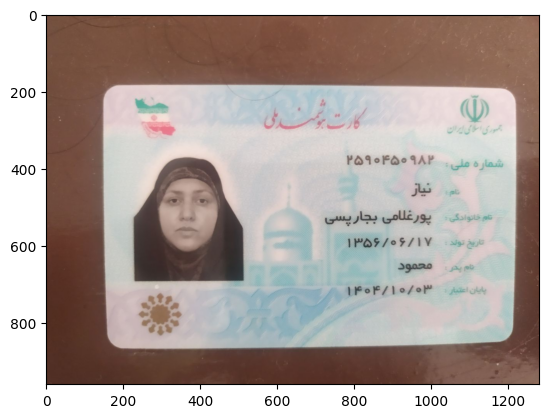

In [21]:
# your code here #
# your code here #
filename = 'images/Q4/8.jpg'
# filename = 'examples/1.png'
image = cv2.imread(filename)
imshow(image)

[[ 149.  200.]
 [ 165.  861.]
 [1212.  833.]
 [1199.  187.]]


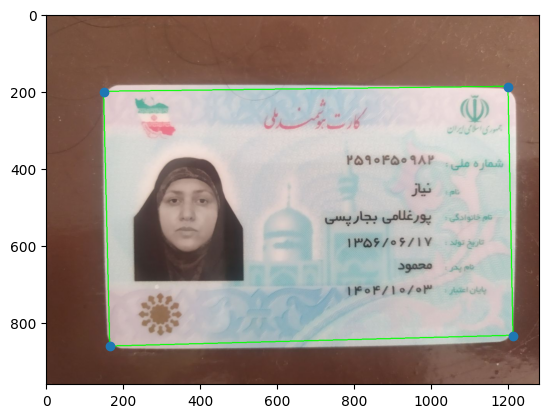

[[ 149.  200.]
 [1199.  187.]
 [1212.  833.]
 [ 165.  861.]]


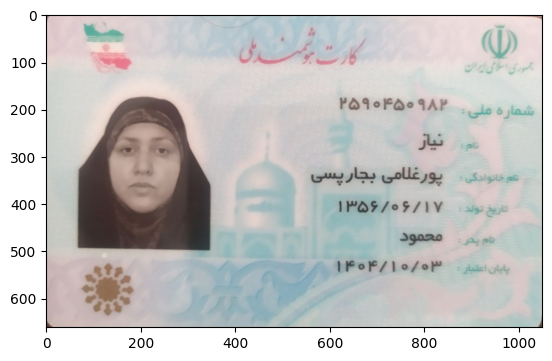

In [22]:
finalimg=project(image)
imshow(finalimg)

In [23]:
def improveimgcrop(imagecrop):
      # Improve image quality
  finalimg1=imagecrop.copy()
  # Create a sharpening kernel
  kernel_sharpening = np.array([[-1,-1,-1],[-1, 9,-1],[-1,-1,-1]])

  # Apply the sharpening kernel to the image
  sharpeimg = cv2.filter2D(finalimg1, -1, kernel_sharpening)

  # Convert the image to the HSV color space
  huesaturationvalue = cv2.cvtColor(sharpeimg, cv2.COLOR_BGR2HSV)

  # Split the image into its hue, saturation, and value components
  hue, saturation, value = cv2.split(huesaturationvalue)

  # Set a limit for the value and saturation channels
  lim = 255 - 40

  # Increase the brightness of the pixels with a low value channel
  value[value > lim] = 255
  value[value <= lim] += 30

  # Increase the saturation of the pixels with a low saturation channel
  saturation[saturation > lim] = 255
  saturation[saturation <= lim] += 35

  # Combine the hue, saturation, and value channels back into an image
  im3 = cv2.merge((hue, saturation, value))

  # Convert the image back to the BGR color space
  improveimg = cv2.cvtColor(im3, cv2.COLOR_HSV2BGR)
  return improveimg

def detectboxnumbers(typecard,imagecrop):
  if typecard=='National card':
    improveimg=improveimgcrop(imagecrop)
    aa=improveimg.copy()
    ss=imagecrop.copy()
    finalimggray=cv2.cvtColor(improveimg,cv2.COLOR_BGR2GRAY)

    # Threshold the image
    ret, thresh6 = cv2.threshold(finalimggray, 100, 255, cv2.THRESH_BINARY)

    # Apply the Sobel filter
    sobelx = cv2.Sobel(thresh6, cv2.CV_8U, 1, 0, ksize=3)
    sobelx=np.abs(sobelx)

    # # Apply thresholding to convert the image to black and white
    # thresh_value = 100
    # ret, thresh = cv2.threshold(sobelx, thresh_value, 255, cv2.THRESH_BINARY)


    # Define the vertical structuring element
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 4))

    # Apply the morphological opening operation
    opened = cv2.morphologyEx(sobelx, cv2.MORPH_OPEN, kernel)

    # Define the horizontal structuring element
    kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT, (55, 8))

    # Apply the morphological closing operation
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel1)
    contours, hierarchy = cv2.findContours(closed,
        cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    rectangles = []
    # Draw bounding rectangles for each contour
    for cnt in contours:
        # Calculate bounding rectangle for the contour
        x, y, w, h = cv2.boundingRect(cnt)
        # Draw the rectangle on the image
        x-=10
        y-=10
        w+=10
        h+=10
        if x>aa.shape[1]/2 and y<aa.shape[0]/2 and x>=0 and y>=0:
            # cv2.rectangle(aa, (x-10, y-10), (x + w, y + h), (0, 255, 0), 2)
            rectangles.append((x, y, w, h))

    # Find the rectangle with the largest width
    max_width_rectangle = max(rectangles, key=lambda x: x[2])
    # Sort the rectangles by y-coordinate
    rectangles_sorted_by_y = sorted(rectangles, key=lambda x: x[1])

    print(rectangles_sorted_by_y[1][0])

    for i in range(len(rectangles_sorted_by_y)):
        if rectangles_sorted_by_y[i][2]>0.8*max_width_rectangle[2]:
            x= rectangles_sorted_by_y[i][0]
            y=rectangles_sorted_by_y[i][1]
            w=rectangles_sorted_by_y[i][2]
            h=rectangles_sorted_by_y[i][3]
            cropped_image = ss[y:y+h, x:x+w]
            cv2.rectangle(aa, (x, y), (x + w, y + h), (0, 255, 0), 2)
            break
    imshow(aa)
    imshow(cropped_image)
    return cropped_image
  else:
    improveimg=improveimgcrop(imagecrop)
    aa=improveimg.copy()
    ss=imagecrop.copy()
    finalimggray=cv2.cvtColor(improveimg,cv2.COLOR_BGR2GRAY)


    # Apply the Sobel filter
    sobelx = cv2.Sobel(finalimggray, cv2.CV_8U, 1, 0, ksize=3)
    sobelx=np.abs(sobelx)

    # Apply thresholding to convert the image to black and white
    thresh_value = 100
    ret, thresh = cv2.threshold(sobelx, thresh_value, 255, cv2.THRESH_BINARY)


    # Define the vertical structuring element
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 4))

    # Apply the morphological opening operation
    opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    # Define the horizontal structuring element
    kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT, (90, 10))

    # Apply the morphological closing operation
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel1)

    imshow(closed )

    contours, hierarchy = cv2.findContours(closed , 
        cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    max_width = 0
    max_x = 0
    max_y = 0
    max_h = 0
      
    # Draw bounding rectangles for each contour
    for cnt in contours:
        # Calculate bounding rectangle for the contour
        x, y, w, h = cv2.boundingRect(cnt)
        x-=10
        y-=10
        w+=10
        h+=10
        # Draw the rectangle on the image
        # if y+h>(1/2)*aa.shape[0]:
        #     cv2.rectangle(aa, (x, y), (x + w, y + h), (0, 255, 0), 2)
        #     if w > max_width:
        # max_width = w
        # max_x = x
        # max_y = y
        # max_h = h
        cv2.rectangle(aa, (x, y), (x + w, y + h), (0, 255, 0), 2) 
                  
    # Crop the image using the coordinates of the bounding rectangle with maximum width
    # crop_img = ss[max_y:max_y+max_h, max_x:max_x+max_width]
    imshow(aa)
    # return crop_img  


904


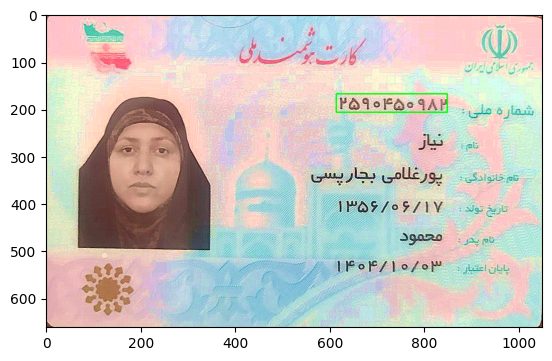

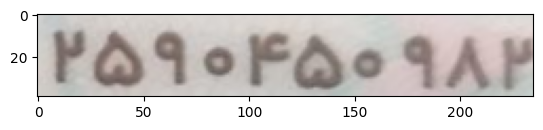

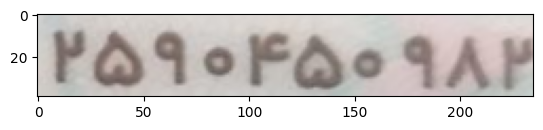

True

In [24]:
boxnum=detectboxnumbers('National card',finalimg)
imshow(boxnum)
cv2.imwrite('test.jpg',boxnum)